In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('kathmandu_aq_ml_ready.csv', parse_dates=['timestamp'])

In [3]:
MICKEY_RED = "#FF0000"
MICKEY_YELLOW = "#FFD700"
MICKEY_BLACK = "#222222"
MICKEY_BLUE = "#00A8E8"

def set_mickey_style():
    sns.set_theme(style="whitegrid")
    plt.rcParams.update({
        'font.weight': 'bold',
        'axes.labelweight': 'bold',
        'axes.titleweight': 'bold',
        'axes.titlesize': 18,
        'axes.labelsize': 14,
        'axes.edgecolor': MICKEY_BLACK,
        'axes.linewidth': 2.5,
        'lines.linewidth': 3
    })

set_mickey_style()

print("🚀 Data Loaded and Mickey Style Active! Ready for Machine Learning.")

🚀 Data Loaded and Mickey Style Active! Ready for Machine Learning.


In [4]:
df.columns

Index(['timestamp', 'pm25', 'temp', 'feelslike', 'dew', 'humidity', 'precip',
       'precipprob', 'preciptype', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation',
       'solarenergy', 'uvindex', 'conditions', 'weather_summary', 'hour',
       'month', 'day_of_week', 'season', 'brick_kiln_active', 'month_sin',
       'month_cos', 'hour_sin', 'hour_cos', 'is_rush_hour', 'is_weekend',
       'pm25_lag_1h', 'pm25_lag_2h', 'pm25_rolling_6h', 'pm25_rolling_24h',
       'precip_lag_3h', 'visibility_lag_3h', 'temp_diff_6h',
       'is_hazardous_now', 'target_next_24h'],
      dtype='object')

In [5]:
df.dtypes.reset_index().rename(
    columns={"index": "column", 0: "dtype"}
)

,column,dtype
0,timestamp,datetime64[ns]
1,pm25,float64
2,temp,float64
3,feelslike,float64
4,dew,float64
5,humidity,float64
6,precip,float64
7,precipprob,int64
8,preciptype,object
9,windgust,float64


In [6]:
cols_to_drop = ['timestamp', 'is_hazardous_now']
df_ml = df.drop(columns=cols_to_drop)

In [7]:
categorical_cols = ['season', 'preciptype', 'conditions', 'weather_summary']
df_ml = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)

In [8]:
df_ml.isnull().sum()

pm25                                   0
temp                                   0
feelslike                              0
dew                                    0
humidity                               0
precip                                 0
precipprob                             0
windgust                               0
windspeed                              0
winddir                                0
sealevelpressure                       0
cloudcover                             0
visibility                             0
solarradiation                         0
solarenergy                            0
uvindex                                0
hour                                   0
month                                  0
day_of_week                            0
brick_kiln_active                      0
month_sin                              0
month_cos                              0
hour_sin                               0
hour_cos                               0
is_rush_hour    

In [9]:
df_ml = df_ml.dropna()

In [10]:
print(f"Final Feature Set: {df_ml.columns.tolist()}")
print(f"Dataset Shape for ML: {df_ml.shape}")

Final Feature Set: ['pm25', 'temp', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex', 'hour', 'month', 'day_of_week', 'brick_kiln_active', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'is_rush_hour', 'is_weekend', 'pm25_lag_1h', 'pm25_lag_2h', 'pm25_rolling_6h', 'pm25_rolling_24h', 'precip_lag_3h', 'visibility_lag_3h', 'temp_diff_6h', 'target_next_24h', 'season_Post-Monsoon', 'season_Pre-Monsoon', 'season_Winter', 'preciptype_rain', 'conditions_Overcast', 'conditions_Partially cloudy', 'conditions_Rain', 'conditions_Rain, Overcast', 'conditions_Rain, Partially cloudy', 'weather_summary_clear-night', 'weather_summary_cloudy', 'weather_summary_fog', 'weather_summary_partly-cloudy-day', 'weather_summary_partly-cloudy-night', 'weather_summary_rain', 'weather_summary_wind']
Dataset Shape for ML: (24479, 50)


In [11]:
X = df_ml.drop(columns=['target_next_24h'])
y = df_ml['target_next_24h']

In [ ]:
split_point = int(len(df_ml) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]
y_train, y_test = y.iloc[:split_point], y.iloc[split_point:]

In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def rf_objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1 
    }

    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for train_index, val_index in tscv.split(X_train_scaled):
        X_t, X_v = X_train_scaled[train_index], X_train_scaled[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        model = RandomForestClassifier(**param)
        model.fit(X_t, y_t)
        
        preds = model.predict(X_v)
        score = f1_score(y_v, preds)
        f1_scores.append(score)

    return np.mean(f1_scores)

rf_study = optuna.create_study(direction='maximize')
print(" Starting RF Optimization for Baluwatar...")
rf_study.optimize(rf_objective, n_trials=20) 

print("\n BEST RF PARAMETERS:")
print(rf_study.best_params)

In [ ]:
def objective(trial):
    # 1. Define the search space (The ranges for the model to try)
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 5, 20), 
        'use_label_encoder': False,
        'eval_metric': 'logloss'
    }

    tscv = TimeSeriesSplit(n_splits=5)
    f1_scores = []

    for train_index, val_index in tscv.split(X_train_scaled):
        X_t, X_v = X_train_scaled[train_index], X_train_scaled[val_index]
        y_t, y_v = y_train.iloc[train_index], y_train.iloc[val_index]

        model = xgb.XGBClassifier(**param)
        model.fit(X_t, y_t)
        
        preds = model.predict(X_v)
        # We focus on the F1-score of the 'Hazardous' class
        score = f1_score(y_v, preds)
        f1_scores.append(score)

    return np.mean(f1_scores)

# 3. Run the Study
study = optuna.create_study(direction='maximize')
print("🚀 Starting Optuna Optimization for Baluwatar...")
study.optimize(objective, n_trials=30) # 30-50 trials is usually enough

print("\n🏆 BEST PARAMETERS FOUND:")
print(study.best_params)

In [ ]:
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42)
best_xgb = xgb.XGBClassifier(**study.best_params)

In [ ]:
ensemble = VotingClassifier(
    estimators=[('lr', lr), ('rf', best_rf), ('xgb', best_xgb)],
    voting='soft'
)

In [ ]:
ensemble.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(class_weight='balanced',
                                                 max_iter=1000)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopp...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [19]:
y_pred = ensemble.predict(X_test_scaled)

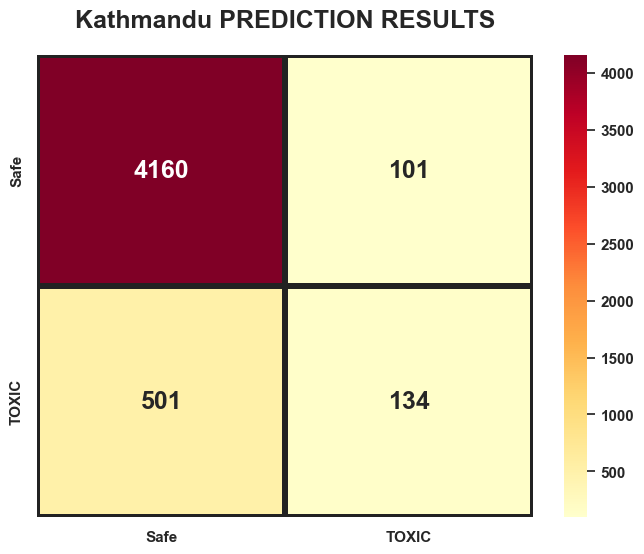

              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93      4261
         1.0       0.57      0.21      0.31       635

    accuracy                           0.88      4896
   macro avg       0.73      0.59      0.62      4896
weighted avg       0.85      0.88      0.85      4896



In [ ]:
def plot_mickey_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd', 
                linewidths=4, linecolor=MICKEY_BLACK,
                xticklabels=['Safe', 'TOXIC'], 
                yticklabels=['Safe', 'TOXIC'],
                annot_kws={"size": 18, "weight": "bold"})
    
    plt.title('Kathmandu PREDICTION RESULTS', pad=20)
    plt.show()
plot_mickey_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

In [32]:
y_probs = ensemble.predict_proba(X_test_scaled)[:, 1]
threshold = 0.25
y_pred_new = (y_probs >= threshold).astype(int)

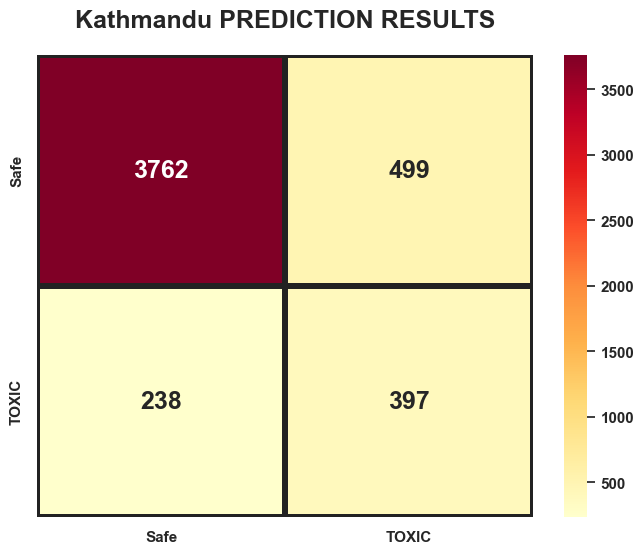

--- NEW PERFORMANCE REPORT (Threshold 0.25) ---
              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91      4261
         1.0       0.44      0.63      0.52       635

    accuracy                           0.85      4896
   macro avg       0.69      0.75      0.71      4896
weighted avg       0.88      0.85      0.86      4896



In [33]:
plot_mickey_confusion_matrix(y_test, y_pred_new)
print("--- NEW PERFORMANCE REPORT (Threshold 0.25) ---")
print(classification_report(y_test, y_pred_new))

C:\Users\bishe\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


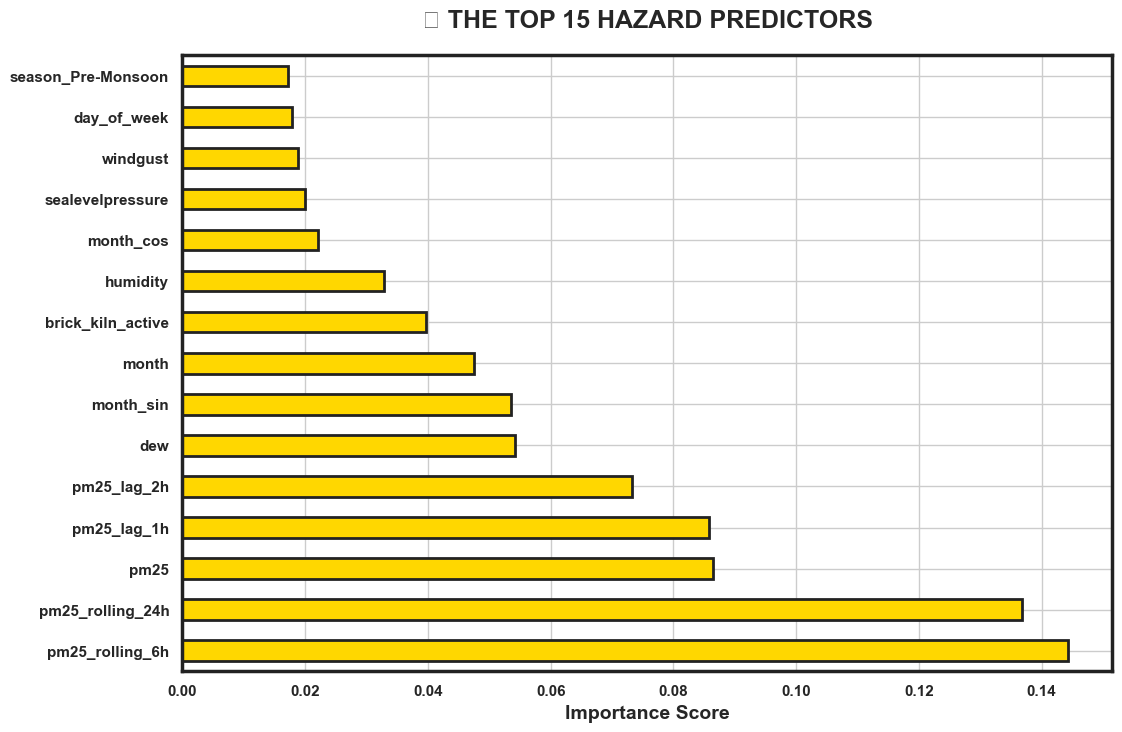

In [24]:
# Extract feature importances from the Random Forest component
# (Note: We use ensemble.estimators_[1] because RF was the second model added)
rf_model = ensemble.estimators_[1]
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a Bold Mickey Plot
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(15).plot(kind='barh', color=MICKEY_YELLOW, edgecolor=MICKEY_BLACK, linewidth=2)

plt.title('🌟 THE TOP 15 HAZARD PREDICTORS', pad=20)
plt.xlabel('Importance Score')
plt.show()

C:\Users\bishe\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


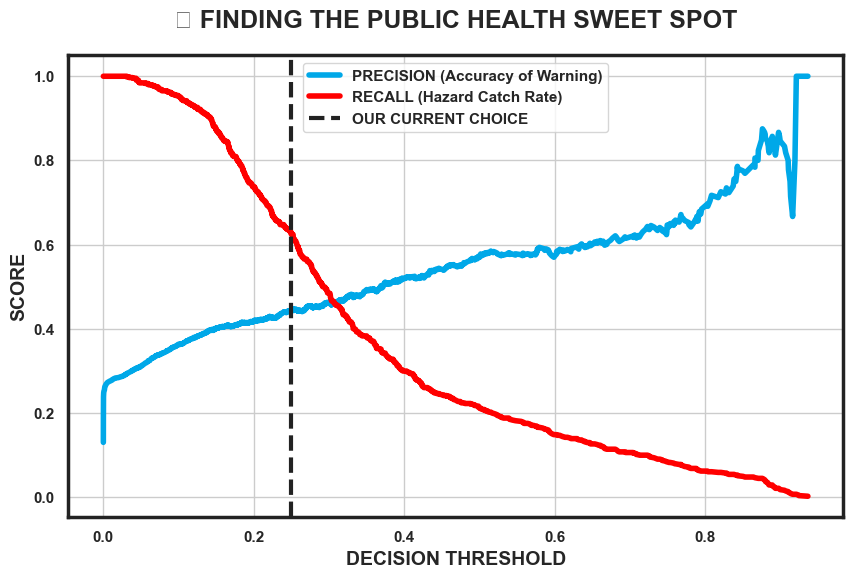

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], color=MICKEY_BLUE, label='PRECISION (Accuracy of Warning)', linewidth=4)
plt.plot(thresholds, recalls[:-1], color=MICKEY_RED, label='RECALL (Hazard Catch Rate)', linewidth=4)

plt.axvline(0.25, color=MICKEY_BLACK, linestyle='--', label='OUR CURRENT CHOICE')

plt.title('FINDING THE PUBLIC HEALTH SWEET SPOT', pad=20)
plt.xlabel('DECISION THRESHOLD')
plt.ylabel('SCORE')
plt.legend()
plt.show()

In [ ]:
from optuna.visualization import plot_optimization_history, plot_param_importances

fig1 = plot_optimization_history(study)
fig1.show()

fig2 = plot_param_importances(study)
fig2.show()